In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

### Camera caliberation

In [62]:
def get_image_object_points(glob_directory='./camera_cal/calibration*.jpg', nx=9, ny=6):
    '''
    Input:
    glob_directory: folder containing images
    nx: number of chess-board corners in the x direction
    ny: number of chess-board corners in the y direction
    
    Output:
    objpoints: 3D object points  
    imgpoints: 2D image points 
    '''
    # Read the caliberation image
    images = glob.glob(glob_directory)
    
    # Array to store object points and image points 
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for fname in images:
        img_ = mpimg.imread(fname)
        img = np.copy(img_)
        
        # Convert to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find chess-board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret: 
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints


def cal_undistort(img, objpoints, imgpoints):
    """
    Input: 
    img: distorted image
    objpoints: 3D object points  
    imgpoints: 2D image points
    """
    undist = None
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    if ret:
        undist = cv2.undistort(img, mtx, dist, None, mtx)

        return undist

In [70]:
# Get object points and image points.
# Obect and images points will be needed when undistorting images later
objpoints, imgpoints = get_image_object_points()

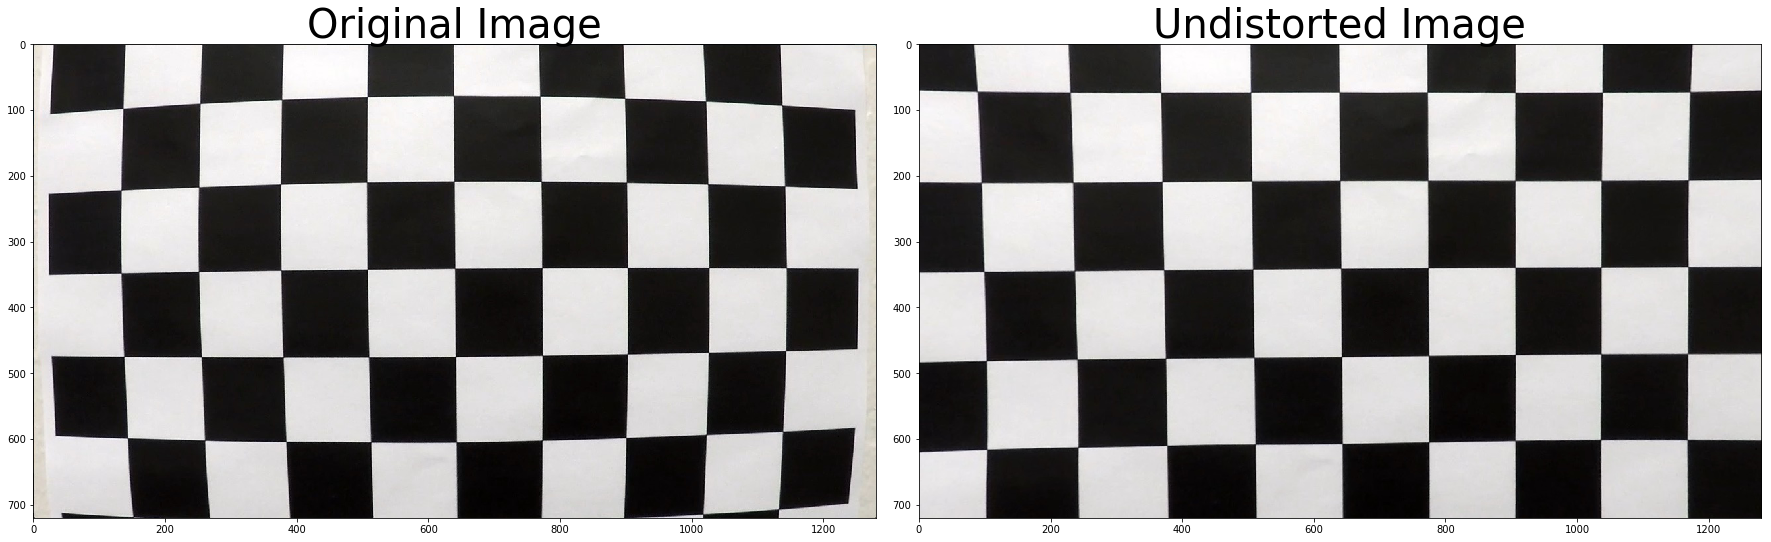

In [83]:
# Plot an example of a distorted chessboard image and its corresponding undistorted version

img = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cal_undistort(img, objpoints, imgpoints)

if undist is not None:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    # Plot the distorted image
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)
    
    # Plot the undistorted image
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=40)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
else:
    print("Undistroted image is None")

### Pipeline for Thresholding

In [242]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    
    """
    Input: 
    img: An mpimg.imread image
    orient: direction over which the sobel operation needs to be performed (either 'x' or 'y')
    thresh_min: pixel values with less than this will be set to 0
    thresh_min: pixel values with more than this will be set to 0
    Output:
    binary_output: An image with shape cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
                   with non-zero pixel values only where the threshold meets the criteria 
    """
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    # Make copy of image
    img = np.copy(img)
    
    # Convert to Gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    sob = None 
    if orient == 'x':
        sob = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sob = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sob)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>thresh_min) & (scaled_sobel<thresh_max)] = 1
    
    # Return this mask as your binary_output image
    return binary_output


def mag_sobel_thresh(image, thresh=(0, 255), sobel_kernel=3):
    """
    Input: 
    img: An mpimg.imread image
    sobel_kernel: An odd number to determine the sobel operation matrix size
    thresh: Threshold to determine the angles which will be picked up
    Output:
    binary_output: An image with shape cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
                   with non-zero pixel values only where the threshold meets the criteria 
    """
    
    img = np.copy(image)
    
    # Convert to Gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))  
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelScaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Create a binary mask where mag thresholds are met
    sobelBinary = np.zeros_like(sobelScaled)
    sobelBinary[(sobelScaled>thresh[0]) & (sobelScaled<thresh[1]) ] =  1
    
    return sobelBinary

    
def abs_dir_thresh(img, thresh=(0, np.pi/2), sobel_kernel=15):
    """
    Input: 
    img: An mpimg.imread image
    sobel_kernel: An odd number to determine the sobel operation matrix size
    thresh: Threshold to determine the angles which will be picked up
    Output:
    binary_output: An image with shape cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
                   with non-zero pixel values only where the threshold meets the criteria 
    """
    
    # Make copy of image
    img = np.copy(img)
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def hls_thresh(img, thresh=(0, 255)):
    """
    Input: 
    img: An mpimg.imread image
    thresh: Threshold to determine the angles which will be picked up
    Output:
    binary_output: An image with shape cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
                   with non-zero pixel values only where the threshold meets the criteria 
    """
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply threshold and create a binary image result
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

    
def pipeline(img, 
             sx_params, sy_params, sdir_params, mag_params, s_color_params,
             objpts=objpoints, imgpts=imgpoints):
    
    sobel_binary_x = None
    sobel_binary_y = None
    sobel_direction = None
    mag_binary = None
    combined = None
    result = None
    
    # Make a copy of the image
    img = np.copy(img)
    
    # Undistort the image
    img = cal_undistort(img, objpts, imgpts)
    
    if img is None:
        return None
    
    # Sobel x operation
    if sx_params["Active"]:
        sobel_binary_x = abs_sobel_thresh(img, sx_params["Orient"], sx_params["Thresh"])
        
    # Sobel y operation
    if sy_params["Active"]:
        sobel_binary_y = abs_sobel_thresh(img, sy_params["Orient"], sy_params["Thresh"])
    
    # Direction gradient
    if sdir_params["Active"]:
        sobel_direction = sobel_direction = abs_dir_thresh(img, sdir_params["Thresh"], sdir_params["Sobel_kernel"])
        
    # Magnitude
    if mag_params["Active"]:
        mag_binary = abs_dir_thresh(img, mag_params["Thresh"], mag_params["Sobel_kernel"])
        
    # Color
    if s_color_params["Active"]:
        s_color_binary = hls_thresh(img, s_color_params["Thresh"])
    
    
    combined = np.zeros_like(sobel_direction)
    #combined[((sobel_binary_x == 1) & (sobel_binary_y == 1)) | ((mag_binary == 1) & (sobel_direction == 1)) | ((s_color_binary==1))] = 1
    combined[((sobel_binary_x == 1) & (sobel_binary_y == 1)) | ((s_color_binary==1))] = 1
    
    return combined
 


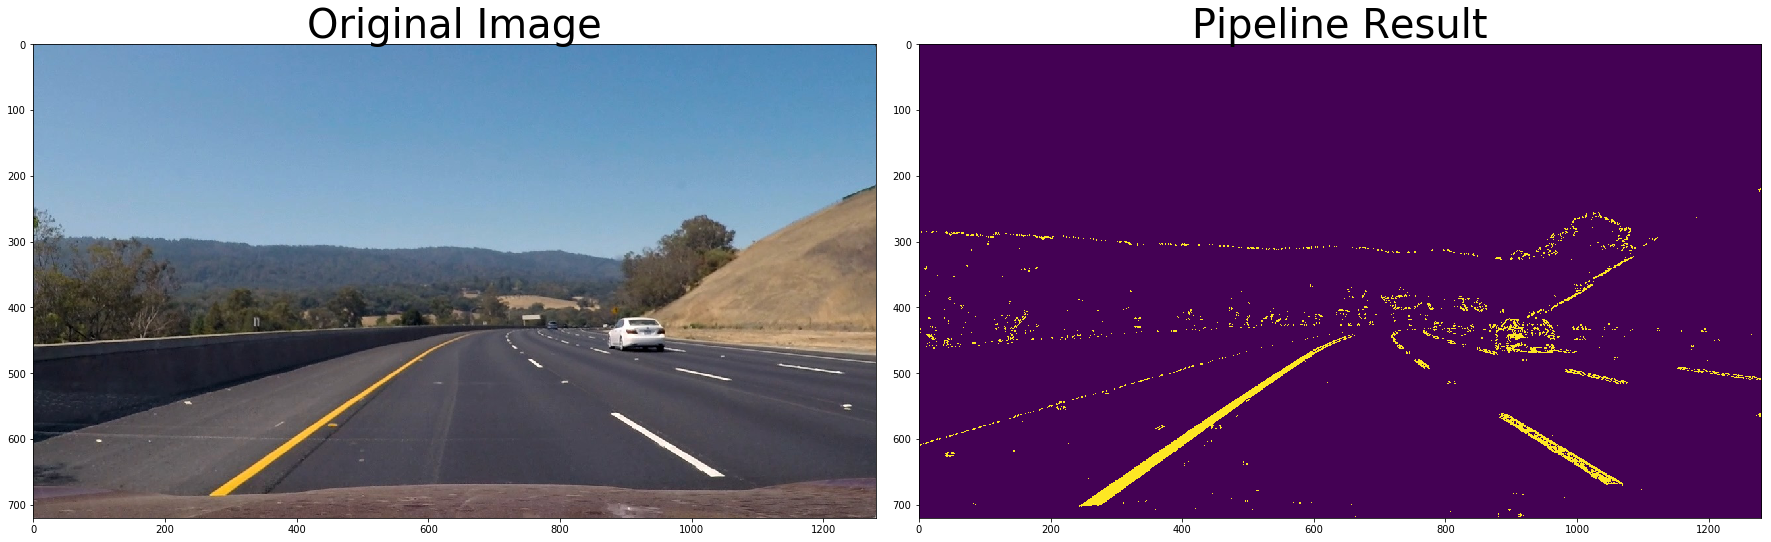

In [523]:
# Making the pipeline

#image = mpimg.imread('./test_images/straight_lines1.jpg')
image = mpimg.imread('./test_images/test3.jpg')

sx_params = {"Active": True, "Orient":'x', "Thresh":(20, 190)}
sy_params = {"Active": True, "Orient":'y', "Thresh":(20, 190)}
sdir_params = {"Active": True, "Thresh":(0.8, 1.5), "Sobel_kernel":15}
mag_params = {"Active": True, "Thresh":(0, 255), "Sobel_kernel":3}
s_color_params = {"Active": True, "Thresh":(170, 255)}

result = pipeline(image, sx_params, sy_params, sdir_params, mag_params, s_color_params)

if result is not None:
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [524]:
def get_region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_vertices(image, top_x_axis_offset=5, top_y_axis_offset=10, bottom_x_axis_offset=200):
    """
    Inputs: 
    image: any image (can be a binary image too)
    x_axis_offset: 
    y_axis_offset:
    Output:
    vertices
    """
    img = np.copy(image)
    imshape = img.shape
    
    vertices = np.array([[( bottom_x_axis_offset,imshape[0]),
                      (imshape[1]/2 - top_x_axis_offset, imshape[0]/2 + top_y_axis_offset), 
                      (imshape[1]/2 + top_x_axis_offset, imshape[0]/2 + top_y_axis_offset), 
                      (imshape[1]- bottom_x_axis_offset,imshape[0])]], dtype=np.int32)
    
    return vertices

### Masking-Region of interest

masked_region.shape =  (720, 1280)


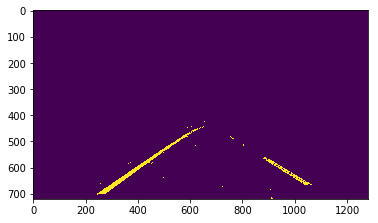

In [525]:
top_x_axis_offset=10
top_y_axis_offset=60
bottom_x_axis_offset=120
vertices = get_vertices(result, top_x_axis_offset, top_y_axis_offset, bottom_x_axis_offset)

masked_region = get_region_of_interest(result, vertices)
print("masked_region.shape = ", masked_region.shape)
plt.imshow(masked_region)

### Perspective transform

In [528]:
def four_point_perspective_transform(image):
    
    img = np.copy(image)
    
    src = np.float32([[  220.,   720.], [  555.,   480.], [  730.,   480.], [ 1100.,   720.]])
    dst = np.float32([[300, 720], [300, 0], [1280 - 300, 0], [1280 - 300, 720]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
        
    im_shape = (img.shape[1], img.shape[0])
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, im_shape, flags=cv2.INTER_LINEAR)
    
    # Convert warped to binary image
    #binary_warped = np.zeros_like(warped)
    #binary_warped[(warped != 0)] = 1
    
    return M, warped

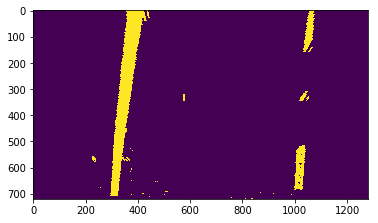

43738.0


In [539]:
"""
original_image = mpimg.imread('./test_images/test3.jpg')
M, binary_warped = four_point_perspective_transform(cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY))
"""

M, binary_warped = four_point_perspective_transform(masked_region)
plt.imshow(binary_warped)
plt.show()

print(sum(sum(binary_warped)))

### Detect lane pixels

In [541]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    print("good_left_inds = ", good_left_inds)
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
print(leftx)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

good_left_inds =  [40143 40144 40145 ..., 43685 43686 43687]
good_left_inds =  [34381 34382 34383 ..., 40111 40112 40113]
good_left_inds =  [29881 29882 29883 ..., 34345 34346 34347]
good_left_inds =  [26461 26462 26463 ..., 29878 29879 29880]
good_left_inds =  [22123 22124 22125 ..., 26458 26459 26460]
good_left_inds =  [18083 18084 18085 ..., 22108 22109 22110]
good_left_inds =  [13863 13864 13865 ..., 18080 18081 18082]
good_left_inds =  [ 7312  7313  7314 ..., 13845 13846 13847]
good_left_inds =  [   0    1    2 ..., 7280 7281 7282]
[299 300 301 ..., 411 412 413]


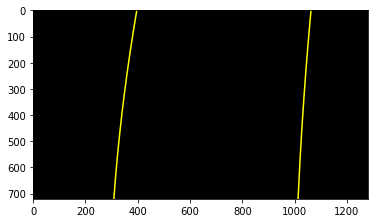

In [542]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

In [536]:
print(M)

[[ -5.50607287e-01  -1.48211876e+00   9.74493927e+02]
 [ -1.49880108e-15  -2.13765182e+00   1.02607287e+03]
 [ -2.71050543e-18  -2.37854251e-03   1.00000000e+00]]
